In [8]:
import os, sys
sys.path.append(os.path.expanduser(os.path.join("~", "Projects", "birkhoff")))
sys.path.append('/Users/Cybele/GIT/birkhoff/birkhoff/')
sys.path.append('/Users/Cybele/GIT/birkhoff/src/')
sys.path.append('/Users/Cybele/GIT/birkhoff/')

import numpy as np
from autograd.scipy.misc import logsumexp

from copy import deepcopy
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
import timeit

from birkhoff.primitives import  gaussian_logp, gaussian_entropy, \
    psi_to_birkhoff, log_det_jacobian, birkhoff_to_psi, \
    birkhoff_to_perm, logistic, logit
    
import seaborn as sns
sns.set_context("talk")
sns.set_style("white")

color_names = ["red",
               "windows blue",
               "amber",
               "faded green",
               "dusty purple",
               "orange",
               "clay",
               "pink",
               "greyish",
               "light cyan",
               "steel blue",
               "pastel purple",
               "mint",
               "salmon"]
colors = sns.xkcd_palette(color_names)
sns.set_style("white")
sns.set_context("paper")

from scipy.optimize import linear_sum_assignment
import autograd.scipy as scipy
import autograd.numpy as np
import autograd.numpy.random as npr
from autograd import grad
from autograd.optimizers import adam, sgd


In [9]:
# Global parameters
#npr.seed(0)
K = 100
D = 2
eta = 0.1
# Optimization parameters
num_adam_iters = 1
num_mcmc_samples = 1

# Sample a true permutation (in=col, out=row)
# perm_true = npr.permutation(K)
perm_true = np.arange(K)[::-1]
#perm_true = np.arange(K)
P_true = np.zeros((K, K))
P_true[np.arange(K), perm_true] = 1

# Sample data according to this permutation
xs = npr.randn(K, D)
xs_perm = P_true.T.dot(xs)
ys = xs_perm + eta * npr.randn(K, D)

M = np.zeros((K,K))
listchar = npr.choice(K, K,replace= False)

for m in listchar:
    i = np.where(P_true[m,:] ==1)[0]
    #M[m, [j for j in range(K) if j not in [i]]] = 1e-8
    random = npr.choice(K, 40, replace = False)
    M[m, [j for j in random if j not in [i]]] = -100000





([], <a list of 0 Text yticklabel objects>)

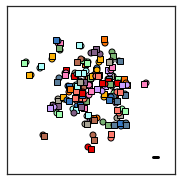

In [10]:
# Plot to and from
fig = plt.figure(figsize=(3,3))
lim = max(abs(ys).max(), abs(xs).max())
for k in range(K):
    plt.plot(xs[k, 0], xs[k, 1], 'o',
             color=colors[k % len(colors)],  markersize=6,
             markeredgecolor='k', markeredgewidth=1)
    plt.plot(ys[perm_true[k], 0], ys[perm_true[k], 1], 's',
             markersize=6, color=colors[k % len(colors)],
             markeredgecolor='k', markeredgewidth=1)

# Scale bar
plt.plot([lim-2*eta,lim], [-lim,-lim], '-k', lw=3)

plt.xlim([-1.25*lim, 1.25*lim])
plt.ylim([-1.25*lim, 1.25*lim])
plt.xticks([])
plt.yticks([])

In [11]:
# Compute the MAP assignment
score = np.zeros((K, K))
for i in range(K):
    for j in range(K):
#         score[i,j] = -0.5 * np.sum((ys[j] - xs[i])**2) / eta**2 
        score[i,j] = np.sum(gaussian_logp(ys[j], xs[i], eta))
row, col = linear_sum_assignment(-score)
P_map = np.zeros((K, K))
P_map[row, col] = 1


In [12]:
def bhatta ( hist1,  hist2):
    return np.sqrt(1-np.sum(np.sqrt(hist1 * hist2)))
    

# Set up the log probability objective
# Assume a uniform prior on P?
# Right now this is just the likelihood...
def perm_to_P(perm):
        K=len(perm)
        P = np.zeros((K,K))
        P[range(K),perm] = 1 
        return P

def round_to_perm(P):
    from scipy.optimize import linear_sum_assignment
    K = P.shape[0]
    
    assert P.shape == (K, K)
    row, col = linear_sum_assignment(-P)
    P = np.zeros((K, K))
    P[row, col] = 1.0
    return P

def n_correct(P1,P2):
    return P1.shape[0]- np.sum(np.abs(P1-P2))/2.0


In [13]:
def sinkhorn_logspace(logP, niters=10):
    for _ in range(niters):
        # Normalize columns and take the log again
        logP = logP - logsumexp(logP, axis=0, keepdims=True)
        # Normalize rows and take the log again
        logP = logP - logsumexp(logP, axis=1, keepdims=True)
    return logP


def rounding_unpack_params(params, K, M, limit_sigma, limit_temp):
    indexes = np.where(M.flatten() == 0)
    logit_mu = []
    logit_sigma = []
   
    cont = 0
    n_params =len(indexes[0])
    
    for i in range(K*K):
        if i in indexes[0]:
            logit_mu.append(params[:n_params][cont])
            logit_sigma.append(params[n_params:][cont])
            cont+=1
        else:
            logit_mu.append(0)
            logit_sigma.append(1)
    #return unpack_params(params,K)
    
    
    temp = limit_temp[0] + (limit_temp[1] - limit_temp[0]) * logistic(params[-1])
    logit_mu = params[:n_params]
    logit_sigma = params[n_params:-1]
    
    logit_mu = np.reshape(np.array(logit_mu),(K,K))
    logit_sigma = np.reshape(np.array(logit_sigma), (K,K))
                             
    mu = np.exp(sinkhorn_logspace(logit_mu + M))
    sigma = limit_sigma[0] + (limit_sigma[1] - limit_sigma[0]) * logistic(logit_sigma)
    
    return mu, sigma, temp 

def rounding_sample_to_pi(sample, temp):
    
    #start_time = timeit.default_timer()
    #s = sample * temp + (1 - temp) * round_to_perm(sample )
   
    return sample
    


def rounding_get_samples(params, noise, temp, limits_sigma, M):
   
    K = noise.shape[1]
    mu, sigma = params
    sample = mu + noise* sigma
    return (sample, np.array([rounding_sample_to_pi(sample[i,:,:], temp) for i in range(sample.shape[0])]))
    
def rounding_log_density_gaussian(sigma, temp, K):
    
    log_sigma = np.log(sigma) 
    entropy = 0.5 * log_sigma.size * (1.0 + np.log(2 * np.pi)) + np.sum(log_sigma)
    
    return entropy + K *(K) * np.log(temp)



In [14]:
# Build variational objective. The variational dist is 
# a diagonal Gaussian over the (K-1)**2 parameters


# Build variational objective. The variational dist is 
# a diagonal Gaussian over the (K-1)**2 parameters

def log_prob(P, xs, ys, eta):
    
    return np.sum(gaussian_logp(ys, np.dot(P.T, xs), eta))

def log_prior(P, sigma_prior, K ):
    """Consider a product (coordinate-wise) of mixtures of two gaussians with std sigma_prior and centers at 0 and 1)"""
    mixture_centers = [0 , 1]
    differences = np.tile(np.reshape(P, (K , K,1)), (1, 1, 2)) - mixture_centers
    n = K * K 
    
    return np.sum(logsumexp(- (differences ** 2 / (2 * sigma_prior )**2), axis = 2)) - n/2 *np.log( 2* np.pi) \
    - n* np.log(2) - n*np.log(sigma_prior)

def variational_objective(params, t, M, sigma_prior, limit_sigma, limit_temp, gen_data, num_mcmc_samples):
    
    K = M.shape[0]
    xs, ys, eta = gen_data

    """Provides a stochastic estimate of the variational lower bound."""
    noise = npr.randn(num_mcmc_samples, K, K)

    mu, sigma, temp = rounding_unpack_params(params,  K, M, limit_sigma, limit_temp)
    #print temp
    (samples, P_samples) = rounding_get_samples([mu, sigma], noise, temp, limit_sigma, M)
    elbo = 0
    log_priors = 0
    log_probs = 0
    for P in P_samples:
        log_priors+= log_prior(P, sigma_prior, K) / num_mcmc_samples
        log_probs+= log_prob(P, xs, ys, eta) / num_mcmc_samples 
    elbo = elbo + rounding_log_density_gaussian(sigma, temp, K) + log_priors + log_probs
    #return [-elbo, log_priors, log_density_gaussian(sigma, temp, limits_sigma, K), log_probs]
    return -elbo


def callback(params, t, g, perline=2):

    cont_iter.append(t)
    num_mcmc_samples = 1
    elbos.append(variational_objective(params, t, M, sigma_prior, limit_sigma, limit_temp, (xs,ys, eta), num_mcmc_samples))
    params_all.append(params)


In [18]:
print("Variational inference for matching...")
print("Initializing with MAP estimate")
# Global parameters
#npr.seed(0)

def temperature(i):
    tau0=1
    MIN_TEMP = 1
    ANNEAL_RATE = 0.1
    np_temp=np.maximum(tau0*np.exp(-ANNEAL_RATE*i),MIN_TEMP)
    return np_temp

num_adam_iters = 10
num_mcmc_samples = 5
stepsize = 0.1
indexes = np.where(M.flatten() == 0)

n_params = len(indexes[0])

limit_sigma=np.array([0, 0.2])
limit_temp = [1, 1]

#print init_var_params.shape
elbos=[]
sigma_prior = 5

lambda0 = 1


Variational inference for matching...
Initializing with MAP estimate


In [ ]:


var_objective = lambda x,t: variational_objective(x, t, M, sigma_prior, limit_sigma, limit_temp, (xs,ys,eta),num_mcmc_samples)
gradient = grad(var_objective)

flag = 1

P0 = np.exp(sinkhorn_logspace(npr.randn(K,K)))
P_init = lambda0 * P0 + (1-lambda0) * P_map
init_mean = np.log(P_init).flatten()
init_logit_std = npr.randn(n_params)
init_var_params = np.concatenate([init_mean, init_logit_std])
init_var_params = np.hstack((init_var_params, 0))

elbos = []
params_all=[]
cont_iter =[]

import itertools as it
variational_params = adam(gradient, init_var_params, step_size=stepsize, num_iters=num_adam_iters, callback = callback)


[ 4.  0.  0.  1.  1.  0.  1.  0.  2.  1.]


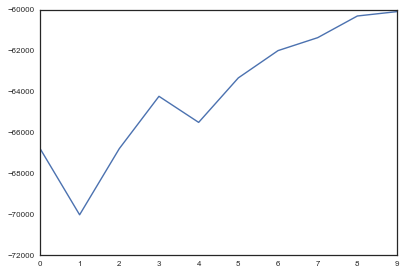

In [20]:
N_sample = 10
plt.plot(-np.array(elbos))

mu, sigma, temp = rounding_unpack_params(variational_params[0], K , M, limit_sigma, limit_temp)
#mu, sigma, temp = rounding_unpack_params(init_var_params, K , M, limit_sigma, limit_temp)

(sample, Psi_sample) = rounding_get_samples([mu, sigma], npr.randn(N_sample, K, K),  temp, limit_sigma, M)

#Kfac = np.prod(np.arange(1, K+1))

# post_inf = {}
# for perm in it.permutations(np.arange(K)):
#     post_inf[perm] = 0
list_perm =[]
n_corrects = np.zeros(N_sample)
for s in range(N_sample):
    # Round doubly stochastic matrix P to the nearest permutation matrix
    row, col = linear_sum_assignment(-Psi_sample[s])
    n_corrects[s] = n_correct(perm_to_P(col), P_true)
    list_perm.append(tuple(col))
#     post_inf[tuple(col)] += 1

# post_inf_vec = np.zeros(Kfac)
# for i, perm in enumerate(it.permutations(np.arange(K))):
#     post_inf_vec[i] = post_inf[perm]

# post_inf_vec = post_inf_vec / post_inf_vec.sum()
# post_inf_vec_sort = post_inf_vec[sort]

print n_corrects

In [ ]:
plt.imshow(M)